In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


C:\Users\roger\AppData\Local\Temp\ipykernel_18184\2816518301.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


### Import and process the data

In [2]:
import pandas as pd
import numpy as np

# Correct URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

# Read the data
data = pd.read_csv(url, header=None)

# Assign column names (based on UCI documentation)
data.columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol',
    'fbs', 'restecg', 'thalach', 'exang', 'oldpeak',
    'slope', 'ca', 'thal', 'target'
]

# Replace '?' with NaN and drop rows with missing values
data = data.replace('?', np.nan)
data = data.dropna()

# Convert numeric columns to float (if necessary)
data = data.astype(float)

# Display the cleaned data
print(data.head())


    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0     0.0  
1    2.0  3.0   3.0     2.0  
2    2.0  2.0   7.0     1.0  
3    3.0  0.0   3.0     0.0  
4    1.0  0.0   3.0     0.0  


In [3]:
## describe the data
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


C:\Users\roger\AppData\Local\Temp\ipykernel_18184\3989774082.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


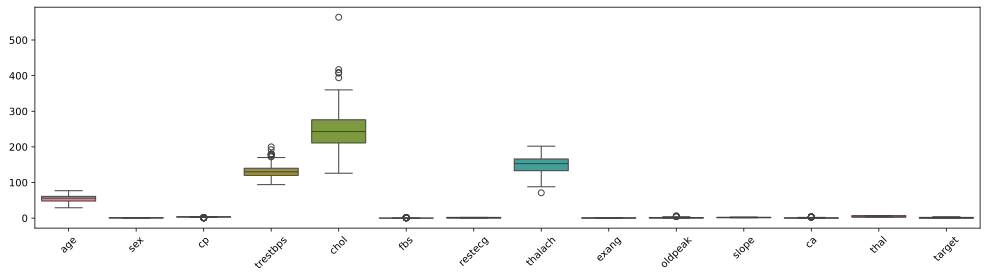

In [4]:
import seaborn as sns
fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [5]:
# Select numeric columns to z-score normalize (excluding binary/categorical ones)
cols2zscore = data.columns.drop(['sex', 'fbs', 'exang', 'target'])

# Apply z-score normalization
for c in cols2zscore:
    data[c] = (pd.to_numeric(data[c]) - data[c].mean()) / data[c].std(ddof=1)


C:\Users\roger\AppData\Local\Temp\ipykernel_18184\3989774082.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


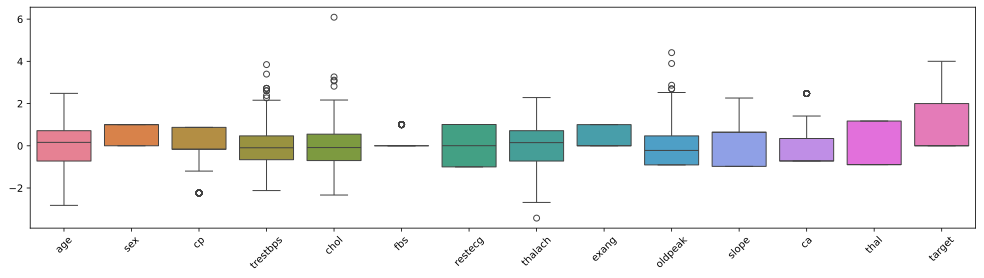

In [6]:
import seaborn as sns
fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [7]:
data['target'].value_counts()
# Convert all non-zero target values to 1 (binary classification)
data['target'] = (data['target'] > 0).astype(int)

data['target']

0      0
1      1
2      1
3      0
4      0
      ..
297    1
298    1
299    1
300    1
301    1
Name: target, Length: 297, dtype: int64

### Re-organize the data : train/test in DataLoader

In [8]:
dataT=torch.tensor(data[data.keys().drop('target')].values).float()
labelsT=torch.tensor(data['target'].values).float()

print(dataT.shape)
print(labelsT.shape)

labels=labelsT[:,None]
print(labels.shape)

torch.Size([297, 13])
torch.Size([297])
torch.Size([297, 1])


In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(
        dataT, labelsT, train_size=50)

train_data=TensorDataset(train_data,train_labels)

test_data=TensorDataset(test_data,test_labels)
batchsize=20
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [12]:
for X,y in train_loader:
    print(X.shape,y.shape)

torch.Size([20, 13]) torch.Size([20])
torch.Size([20, 13]) torch.Size([20])


### Create a class for the DL model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the network
class theNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(13, 32)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x


In [19]:
# Initialize the model
net = theNet()

# Get one batch of data
X, y = next(iter(train_loader))

# Ensure X is float and y is float and reshaped correctly
X = X.float()
y = y.float().view(-1, 1)  # BCEWithLogitsLoss expects shape [batch_size, 1]

# Forward pass
yHat = net(X)
print(yHat)

# Define loss function
lossfun = nn.BCEWithLogitsLoss()

# Compute loss
loss = lossfun(yHat, y)
print("Loss:", loss.item())


tensor([[-0.0735],
        [-0.0811],
        [-0.0923],
        [-0.0396],
        [-0.0695],
        [-0.0511],
        [-0.0598],
        [-0.0769],
        [-0.1048],
        [-0.0851],
        [-0.0714],
        [-0.0879],
        [-0.1211],
        [-0.1036],
        [-0.0691],
        [-0.0763],
        [-0.0659],
        [-0.0986],
        [-0.1012],
        [-0.0987]], grad_fn=<AddmmBackward0>)
Loss: 0.6859445571899414


### Train the model and show performance

In [21]:
import torch
import numpy as np

net = theNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
lossfun = nn.BCEWithLogitsLoss()
numepochs = 100

trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

for epochi in range(numepochs):
    batchLoss = []
    batchAcc = []

    net.train()
    for X, y in train_loader:
        X = X.float()
        y = y.float().view(-1, 1)  # reshape y

        # Forward pass
        yHat = net(X)
        loss = lossfun(yHat, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record loss and accuracy
        batchLoss.append(loss.item())
        predictions = (torch.sigmoid(yHat) > 0.5).float()
        acc = 100 * torch.mean((predictions == y).float())
        batchAcc.append(acc.item())

    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = np.mean(batchAcc)

    # ---- Evaluation on test set ----
    net.eval()
    with torch.no_grad():
        X, y = next(iter(test_loader))
        X = X.float()
        y = y.float().view(-1, 1)

        yHat = net(X)
        loss = lossfun(yHat, y)
        testLoss[epochi] = loss.item()

        predictions = (torch.sigmoid(yHat) > 0.5).float()
        acc = 100 * torch.mean((predictions == y).float())
        testAcc[epochi] = acc


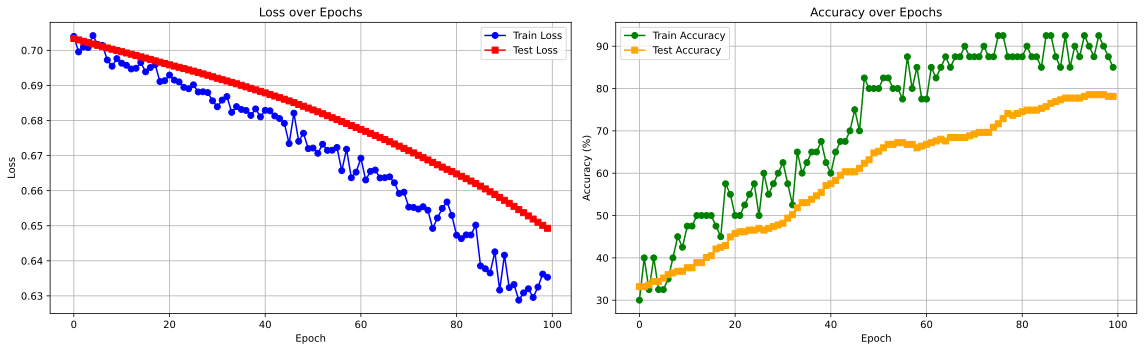

In [22]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# ---------- Plot 1: Loss ----------
ax[0].plot(trainLoss, label='Train Loss', color='blue', marker='o')
ax[0].plot(testLoss, label='Test Loss', color='red', marker='s')
ax[0].set_title('Loss over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# ---------- Plot 2: Accuracy ----------
ax[1].plot(trainAcc, label='Train Accuracy', color='green', marker='o')
ax[1].plot(testAcc, label='Test Accuracy', color='orange', marker='s')
ax[1].set_title('Accuracy over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()
ax[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [23]:
import torch
import numpy as np

net = theNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
lossfun = nn.MSELoss()
numepochs = 100

trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

for epochi in range(numepochs):
    batchLoss = []
    batchAcc = []

    net.train()
    for X, y in train_loader:
        X = X.float()
        y = y.float().view(-1, 1)  # reshape y

        # Forward pass
        yHat = net(X)
        loss = lossfun(yHat, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record loss and accuracy
        batchLoss.append(loss.item())
        predictions = (torch.sigmoid(yHat) > 0.5).float()
        acc = 100 * torch.mean((predictions == y).float())
        batchAcc.append(acc.item())

    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = np.mean(batchAcc)

    # ---- Evaluation on test set ----
    net.eval()
    with torch.no_grad():
        X, y = next(iter(test_loader))
        X = X.float()
        y = y.float().view(-1, 1)

        yHat = net(X)
        loss = lossfun(yHat, y)
        testLoss[epochi] = loss.item()

        predictions = (torch.sigmoid(yHat) > 0.5).float()
        acc = 100 * torch.mean((predictions == y).float())
        testAcc[epochi] = acc


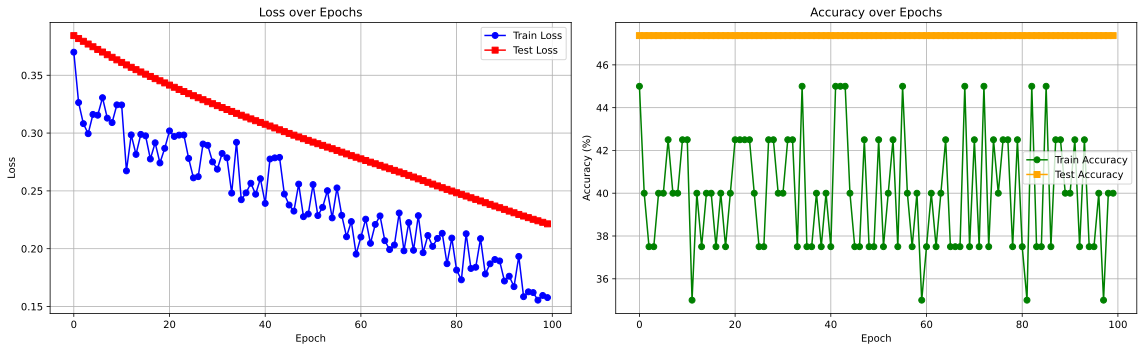

In [24]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# ---------- Plot 1: Loss ----------
ax[0].plot(trainLoss, label='Train Loss', color='blue', marker='o')
ax[0].plot(testLoss, label='Test Loss', color='red', marker='s')
ax[0].set_title('Loss over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# ---------- Plot 2: Accuracy ----------
ax[1].plot(trainAcc, label='Train Accuracy', color='green', marker='o')
ax[1].plot(testAcc, label='Test Accuracy', color='orange', marker='s')
ax[1].set_title('Accuracy over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()
ax[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()
